In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from pathlib import Path
from typing import Tuple, Callable, Any
from abc import abstractmethod, ABC
from functools import partial
from collections import defaultdict

import torch 

from transformer_lens import HookedTransformer

from cupbearer import tasks
from cupbearer import utils
from cupbearer.detectors import AnomalyDetector, ActivationBasedDetector
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
from cupbearer.data import MixedData

from elk_experiments.eap_detector import set_model
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.utils import repo_path_to_abs_path

from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.data import PromptDataset, PromptDataLoader, to_device
from auto_circuit.types import AblationType, PatchType, PruneScores, CircuitOutputs, PatchWrapper
from auto_circuit.utils.ablation_activations import src_ablations, batch_src_ablations
from auto_circuit.utils.graph_utils import patch_mode, patchable_model
from auto_circuit.utils.tensor_ops import desc_prune_scores, prune_scores_threshold
from auto_circuit.utils.misc import module_by_name

In [3]:
model_name = "gpt2-small"
device = "cuda"
task_name = "ifelse"
task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 2048, 1024, 1024)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cuda


/nas/ucb/oliveradk/miniforge3/envs/elk-experiments/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


In [4]:
def make_prompt_dataset(data, effect_tokens, vocab_size):
    clean_prompts = [x[0] for x in data]
    answers = [effect_tokens] * len(clean_prompts)
    wrong_answers = [list(set(range(vocab_size)) - set(answer)) for answer in answers]
    
    # put into torch tensors
    clean_prompts = torch.stack(clean_prompts, dim=0)
    corrupt_prompts = torch.stack([torch.zeros_like(clean_prompts[0], dtype=int)] * len(clean_prompts), dim=0)
    answers = [torch.tensor(answer, dtype=int) for answer in answers]
    wrong_answers= [torch.tensor(answer, dtype=int) for answer in wrong_answers]

    return PromptDataset(clean_prompts, corrupt_prompts, answers, wrong_answers)

In [5]:
# get mixed data to work with prompt dataloader

In [6]:
test_data = task.test_data
prompt_normal_data = make_prompt_dataset(test_data.normal_data, get_effect_tokens(task_name, task.model), task.model.tokenizer.vocab_size)
prompt_anomalous_data = make_prompt_dataset(test_data.anomalous_data, get_effect_tokens(task_name, task.model), task.model.tokenizer.vocab_size)
prompt_mixed_data = MixedData(prompt_normal_data, prompt_anomalous_data)

In [7]:
from typing import List
Label = int
from auto_circuit.data import PromptPair, PromptPairBatch
import torch as t

In [9]:
def collate_fn(batch: List[Tuple[PromptPair, Label]]) -> Tuple[PromptPairBatch, t.Tensor]:
    clean = t.stack([p.clean for p, y in batch])
    corrupt = t.stack([p.corrupt for p, y in batch])
    labels = t.tensor([y for p, y in batch], dtype=t.int)
    if all([p.answers.shape == batch[0][0].answers.shape for p, y in batch]):
        answers = t.stack([p.answers for p, y in batch])
    else:  # Sometimes each prompt has a different number of answers
        answers = [p.answers for p, y in batch]
    if all([p.wrong_answers.shape == batch[0][0].wrong_answers.shape for p, y in batch]):
        wrong_answers = t.stack([p.wrong_answers for p, y in batch])
    else:  # Sometimes each prompt has a different number of wrong answers
        wrong_answers = [p.wrong_answers for p, y in batch]
    key = hash((str(clean.tolist()), str(corrupt.tolist())))

    diverge_idxs = (~(clean == corrupt)).int().argmax(dim=1)
    batch_dvrg_idx: int = int(diverge_idxs.min().item())
    return PromptPairBatch(key, batch_dvrg_idx, clean, corrupt, answers, wrong_answers), labels


In [10]:
# ok so the ideal thing is we create a mixedData object with prompt datasets, then we use the prompt dataloader 
# the problem I think its that the prompt dataloader doesnt' expect labels?

In [11]:
class AutoCircuitDetector(AnomalyDetector, ABC):

    def __init__(
        self, 
        effect_tokens: list[int],
        prune_scores_func: Callable[[HookedTransformer, PromptDataLoader], Tuple[PruneScores, torch.Tensor]], 
        device: str = "cpu",
        layer_aggregation: str = "mean"
    ):
        self.effect_tokens = effect_tokens
        self.prune_scores_func = prune_scores_func
        self.device = device
        self.pruning_scores: PruneScores
        self.patch_src_outs: torch.Tensor
        super().__init__(layer_aggregation=layer_aggregation)

    def set_model(self, model: HookedTransformer):
        # apply tl hooks
        set_model(model)
        # apply patching wrapper
        self.model = patchable_model(
            model, 
            factorized=True, 
            slice_output="last_seq",
            separate_qkv=True, 
            device=self.device
        )
    
    
    def train(
        self,
        trusted_data,
        untrusted_data,
        save_path: Path | str,
        *,
        batch_size: int = 64,
        **trainer_kwargs,
    ):
        # construct prompt datasets and loaders
        trusted_dataset = make_prompt_dataset(trusted_data, self.effect_tokens, self.model.tokenizer.vocab_size)
        seq_len = trusted_dataset.clean_prompts.size(1)
        trusted_dataloader = PromptDataLoader(
            trusted_dataset, 
            seq_len=seq_len, 
            diverge_idx=0, 
            batch_size=batch_size, 
            shuffle=False
        )

        self.pruning_scores, self.patch_src_outs = self.prune_scores_func(
            model=self.model,
            dataloader=trusted_dataloader
        )

    def _get_trained_variables(self, saving: bool = False):
        return {
            "pruning_scores": self.pruning_scores,
            "patch_src_outs": self.patch_src_outs
        }.update(super()._get_trained_variables(saving))
    
    
    def _set_trained_variables(self, variables):
        self.pruning_scores = variables["pruning_scores"]
        self.patch_src_outs = variables["patch_src_outs"]
        super()._set_trained_variables(variables)

    
    def layerwise_scores(self, batch):
        raise NotImplementedError(
            "Layerwise scores don't exist for finetuning detector"
        )
    
    def eval(
        self,
        dataset: MixedData, 
        batch_size: int = 1024,
        histogram_percentile: float = 95,
        save_path: Path | str | None = None,
        num_bins: int = 100,
        pbar: bool = False,
        layerwise: bool = False,
        log_yaxis: bool = True,
    ):
        #TODO: iterate over multiple k values (logaritmatically?) to get AUROC over thresholds
        # construct data loader
        normal_dataset = make_prompt_dataset(dataset.normal_data, self.effect_tokens, self.model.tokenizer.vocab_size)
        anomalous_dataset = make_prompt_dataset(dataset.anomalous_data, self.effect_tokens, self.model.tokenizer.vocab_size)
        prompt_dataset = MixedData(normal_dataset, anomalous_dataset, dataset.normal_weight, dataset.return_anomaly_labels)
        seq_len = normal_dataset.clean_prompts.size(1)
        dataloader = PromptDataLoader(
            prompt_dataset,
            seq_len=seq_len,
            diverge_idx=0,
            batch_size=batch_size,
            shuffle=False, 
            collate_fn=collate_fn
        )
        return super().eval(
            dataset=None,
            test_loader=dataloader,
            batch_size=batch_size,
            histogram_percentile=histogram_percentile,
            save_path=save_path,
            num_bins=num_bins,
            pbar=pbar,
            layerwise=layerwise,
            log_yaxis=log_yaxis,
        )
    
    @abstractmethod
    def scores(self, batch):
        raise NotImplementedError




In [12]:
def kl_div(patched_logits: torch.Tensor, logits: torch.Tensor):
    # batch x vocab
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    patched_log_probs = torch.nn.functional.log_softmax(patched_logits, dim=-1)
    kl = torch.nn.functional.kl_div(
        patched_log_probs, 
        log_probs,
        reduction="none",
        log_target=True
    ) # batch x vocab
    kl = kl.sum(dim=-1) # batch
    return kl


In [13]:
class AutoCircuitPruningDetector(AutoCircuitDetector):
    def __init__(
        self, 
        effect_tokens: list[int],
        prune_scores_func: Callable[[HookedTransformer, PromptDataLoader], Tuple[PruneScores, CircuitOutputs]], 
        scores_func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        device: str = "cpu",
        k: int | None = None, 
        threshold: float | None = None,
        layer_aggregation: str = "mean",
    ): 
        assert (k is not None) ^ (threshold is not None), "Either k or threshold must be specified"
        self.scores_func = scores_func
        self.k = k
        self.threshold = threshold
        super().__init__(effect_tokens, prune_scores_func, device, layer_aggregation)

    def scores(self, batch):
        # for now, assume we're reusing the patch src outs, mean over tokens
        print(type(batch))
        input = utils.inputs_from_batch(batch)
        print("input", input)
        input = input.clean
        
        circ_outs: CircuitOutputs = defaultdict(dict)
        desc_ps = desc_prune_scores(self.pruning_scores) #TODO: look back at the other method they had
        threshold = prune_scores_threshold(desc_ps, self.k) if self.threshold is None else self.threshold

        # run patched model 
        with patch_mode(self.model, self.patch_src_outs):
            # set patch masks according to threshold
            patch_edge_count = 0 
            for mod_name, patch_mask in self.pruning_scores.items():
                dest = module_by_name(self.model, mod_name)
                assert isinstance(dest, PatchWrapper)
                assert dest.is_dest and dest.patch_mask is not None 
                # "Tree patch" patching all edges below threshold
                dest.patch_mask.data = (patch_mask.abs() < threshold).float()
                patch_edge_count += (1 - dest.patch_mask.int()).sum().item()
            # run model
            with torch.inference_mode():
                patched_logits = self.model(input)[self.model.out_slice]

        # normal output 
        with torch.inference_mode():
            normal_logits = self.model(input)[self.model.out_slice]
        
        # compute scores
        scores = self.scores_func(patched_logits, normal_logits)
        return scores



In [14]:
def kl_div_on_effects(patched_logits: torch.Tensor, logits: torch.Tensor, effect_tokens: list[int]):
    # batch x vocab
    # don't need to worry about numerical stability as much b/c not taking gradients, I guess...
    patched_probs = torch.nn.functional.softmax(patched_logits, dim=-1)
    probs = torch.nn.functional.softmax(logits, dim=-1)
    # compute probability and inverse probability of effect tokens on patched and normal
    patched_effect_prob = patched_probs[:, effect_tokens].sum(dim=-1)
    effect_prob = probs[:, effect_tokens].sum(dim=-1)
    patched_no_effect_prob = 1 - patched_effect_prob
    no_effect_prob = 1 - effect_prob
    # stack probabilities into distribution
    patched_effect_log_dist = torch.stack([patched_effect_prob.log(), patched_no_effect_prob.log()], dim=1)
    effect_log_dist = torch.stack([effect_prob.log(), no_effect_prob.log()], dim=1)
    # take kl divergence betweeen patched and normal
    kl = torch.nn.functional.kl_div(
        patched_effect_log_dist, 
        effect_log_dist,
        reduction="none",
        log_target=True
    ) # batch x 2
    assert kl.shape == (patched_logits.size(0), 2)
    return kl.sum(dim=-1) # batch

In [15]:
from cupbearer import scripts

In [16]:
def concat_batch_src_outs(prune_scores, batch_src_outs: dict[str, torch.Tensor]):
    # concatenate batch src outs
    src_outs = torch.concat([src_out for src_out in batch_src_outs.values()], dim=0)
    return prune_scores, src_outs

In [27]:
effect_tokens = get_effect_tokens(task_name, task.model)
other_tokens = list(set(range(task.model.tokenizer.vocab_size)) - set(effect_tokens))
detector = AutoCircuitPruningDetector(
    effect_tokens=effect_tokens,
    prune_scores_func=lambda model, dataloader: concat_batch_src_outs(
        *mask_gradient_prune_scores(
            model=model, 
            dataloader=dataloader,
            official_edges=None, 
            grad_function="logit", 
            answer_function="avg_diff", 
            ablation_type=AblationType.TOKENWISE_MEAN_CLEAN,
            clean_corrupt=None,
            mask_val=0, 
            return_src_outs=True,
            device=device
        )
    ),
    scores_func=partial(
        kl_div_on_effects, 
        effect_tokens=effect_tokens, 
    ),
    k=200,
    device=device,
    layer_aggregation="mean"
)

In [29]:
detector_dir = repo_path_to_abs_path("output") / f"eap_prune_{task_name}_{model_name}"

In [ ]:
detector.set_model(task.model)

detector.train(
    trusted_data=task.trusted_data,
    untrusted_data=task.untrusted_train_data,
    save_path=detector_dir, 
    batch_size=16, 
)

<class 'auto_circuit.data.PromptPairBatch'>
input PromptPairBatch(key=-5249433695418401741, batch_diverge_idx=0, clean=tensor([[  198,   220,   220,   220,   220,   220,   220,   220,  1441,  2116,
            13,  3672,   611,  2116,    13,  3672],
        [  796,  6407,   611,  1785,    13,  4906,   318, 12972,  6057,    13,
            44,  2606,  5188, 47526, 11357, 41925],
        [47527,    64,  1343,   357,    79,  1220, 12178,     7,    83, 22305,
          1220,   362,    13,    15,   611,   256],
        [  220,   220, 37817,    62,  4868,   796,  2116,    13,  3803,    62,
          2860, 16746,   611,   329,    62,  3803],
        [  220,   220,   220,   220,   220,   220,   220,   352,   611,   267,
            13,  9688,    62,  2676,  1875,   657],
        [  220,   220,   220,   220,   220,   285,   796,  2872,    13,  9688,
          3419,   611,  2872,   318,   407,  6045],
        [  220,   220,   220,   220,   220,   220,   220,  1441,  6045,   611,
          2116, 

2024-07-10 10:23:30.739 | INFO     | cupbearer.detectors.anomaly_detector:eval:155 - AUC_ROC (all): 0.5383
2024-07-10 10:23:30.740 | INFO     | cupbearer.detectors.anomaly_detector:eval:156 - AP (all): 0.5244


<class 'auto_circuit.data.PromptPairBatch'>
input PromptPairBatch(key=3413441902752289649, batch_diverge_idx=0, clean=tensor([[ 5855,    15,     1,  1343,   965,     7,  1084,  1769,  4008,   611,
           357,  1084,  1769,  1279,   838,     8],
        [  220,  3815,   796,   685, 25811,    58,    72,    60,   611,   318,
         39098,     7,    72,    11,   493,     8],
        [  220,   220,   220,   220,   611,  2116,    13,   433, 29660,    62,
         23870,    62, 40779,    62, 25616,  3419],
        [31456,   796, 41575,     7,  2704,  5570,     8,   611,   318, 39098,
             7,  2704,  5570,    11,   965,     8],
        [11201, 12249,     6,   611,  2116,    13, 43551,    62,   271,    62,
          9654,     7, 25927,    11, 10139,     8],
        [18601,   796, 35002,   611,   318, 39098,     7,  2536,  1460,    11,
           357,    83, 29291,    11,  1351,  4008],
        [   11,   257,    11,   685, 49201,     7,    87,     8,   611,   318,
         39098,  

(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5383024215698242,
               'AP': 0.5243734588885546}}),
 {'all': <Figure size 640x480 with 1 Axes>})

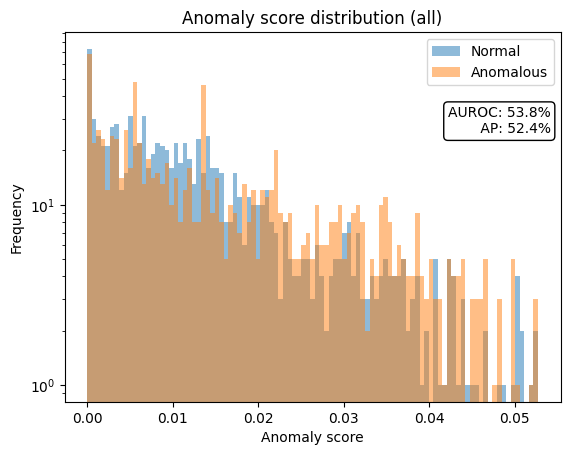

In [30]:
scripts.eval_detector(
    task=task,
    detector=detector,
    save_path=None,
    batch_size=16,
    pbar=True,
    layerwise=False,
)

In [ ]:
# sanity check on mahalanobis

In [ ]:
class AutoCircuitScoresDetector(AutoCircuitDetector, ActivationBasedDetector):
    